In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import utils
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

from gensim.models import Word2Vec  
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
unable to import 'smart_open.gcs', disabling that module
Using TensorFlow backend.


## Preprocess

In [2]:
aita_raw = pd.read_csv("data_output/aita_xy_processed.csv", index_col=0)

def pp_regularize_text(df, body_or_title):
    stop_words = []
    for word in list(stopwords.words('english')):
        word = re.sub(r'[^A-Za-z ]+', '', word)
        stop_words.append(word)

    text_list = []
    for text in df[body_or_title]:
        text = text.lower()
        text = text.replace('\n', ' ').replace('\r', '').replace('’', '\'')
        text = re.sub(r'[^A-Za-z ]+', '', text)
        goodtext = text.encode('cp1252', 'ignore')
        goodtext = goodtext.decode('utf-8', 'ignore')

        token = nltk.word_tokenize(goodtext)
        #token = [y for y in token if not y in stop_words]
        final_text = (" ").join(token)

        text_list.append(final_text)
    df[body_or_title] = text_list
    return df

aita_raw = pp_regularize_text(aita_raw, "body")
aita_raw = pp_regularize_text(aita_raw, "title")
print(aita_raw.shape)
aita_raw.head()

(16390, 4)


,target,binary_target,title,body
0,NTA,0,aita for calling my ex out on his fb post,so little baby j was born his dad had broken u...
1,NTA,0,aita for uninviting my brother from my wedding...,hi everyone im using a throwaway and i just wa...
2,NTA,0,aita for finally poking back at my childfree s...,my wifes sister abby is childfree neither my w...
3,NTA,0,aita for refusing my mils offer of free childcare,throwaway due to the specificity of the detail...
4,NTA,0,aita mil tried to have my baby blessed without...,my mil and fil are first time grandparents who...


In [3]:
x_body = list(aita_raw["body"])
print(len(x_body))
y_target = list(aita_raw["binary_target"])
print(len(y_target))

16390
16390


## Training Word2Vec

In [4]:
def label_sentence(x, label):
    labeled_list = []
    for count in range(len(x)):
        label_count = "%s_%s" % (label, count)
        labeled_list.append(TaggedDocument(x[count].split(), label_count))
    return labeled_list

x_tagged = label_sentence(x_body, "body")

In [5]:
w2v_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2)
w2v_cbow.build_vocab([x.words for x in tqdm(x_tagged)])

100%|██████████| 16390/16390 [00:00<00:00, 1493961.59it/s]


In [6]:
for epoch in range(15):
    w2v_cbow.train(utils.shuffle([x.words for x in tqdm(x_tagged)]), total_examples=len(x_tagged), epochs=1)
    w2v_cbow.alpha -= 0.002
    w2v_cbow.min_alpha = w2v_cbow.alpha

100%|██████████| 16390/16390 [00:00<00:00, 1826517.59it/s]


In [7]:
w2v_cbow.save('data_output/w2v_cbow.word2vec')

In [8]:
w2v_sg = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2)
w2v_sg.build_vocab([x.words for x in tqdm(x_tagged)])

100%|██████████| 16390/16390 [00:00<00:00, 1095514.69it/s]


In [9]:
for epoch in range(15):
    w2v_sg.train(utils.shuffle([x.words for x in tqdm(x_tagged)]), total_examples=len(x_tagged), epochs=1)
    w2v_sg.alpha -= 0.002
    w2v_sg.min_alpha = w2v_sg.alpha

100%|██████████| 16390/16390 [00:00<00:00, 1441519.90it/s]


In [10]:
w2v_sg.save('data_output/w2v_sg.word2vec')

In [11]:
w2v_cbow.most_similar("jerk")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bitch', 0.7999882698059082),
 ('hypocrite', 0.7760356664657593),
 ('dick', 0.7734907865524292),
 ('brat', 0.7628738880157471),
 ('dickhead', 0.7480695843696594),
 ('douche', 0.747770369052887),
 ('liar', 0.7174259424209595),
 ('creep', 0.7078348398208618),
 ('cunt', 0.701038658618927),
 ('prick', 0.6883631944656372)]

In [12]:
w2v_sg.most_similar("jerk")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hypocrite', 0.8088452816009521),
 ('bitch', 0.8079688549041748),
 ('dick', 0.7705961465835571),
 ('creep', 0.762449324131012),
 ('brat', 0.7470883131027222),
 ('dickhead', 0.7465746402740479),
 ('douche', 0.7392672300338745),
 ('prick', 0.7223894000053406),
 ('liar', 0.7180142402648926),
 ('cunt', 0.7178034782409668)]

## Tokenization

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_body, y_target, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(len(X_train), len(X_test))

9219 4098


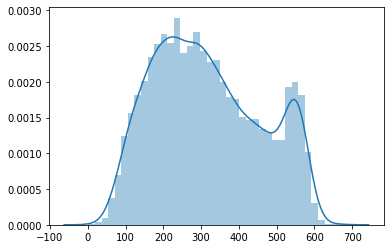

In [14]:
length = []
for x in x_body:
    length.append(len(x.split()))
sns.distplot(length)

In [15]:
def tokenize(df, body_or_title):
    tokenizer = Tokenizer(num_words=100000)
    tokenizer.fit_on_texts(df[body_or_title])
    return tokenizer

def pp_token_sequence_pad(list_docs, tokenizer):
    seq = tokenizer.texts_to_sequences(list_docs)
    seq = pad_sequences(seq, maxlen=600)
    return seq

In [16]:
tokenizer = tokenize(aita_raw, "body")
seq_train = pp_token_sequence_pad(X_train, tokenizer)
seq_test = pp_token_sequence_pad(X_test, tokenizer)

In [17]:
X_test[4]

'some backstory my father isnt a part of my life at all he divorced my mom when i was but even then i was indifferent i was indignant for a while because it was particularly hard on my mom but it didnt affect me personally that much because he was largely absent to begin with one further step removed didnt change my life were cordial but dont see each other i have seen my father once in the last ten years and literally only for ten minutes in passing wasnt planned he lives on the other side of the country i had a son two years ago i never told him because hes not involved in my life last week the wife and i had our wedding anniversary and my cousin babysat for us i learned after the fact my father was in the area and my cousin brought my son to him for a visit they planned this in advance apparently and my father didnt come to me directly because he thought id say no and i would have you cant forge a relationship with your grandson if you failed to with your son i never would have foun

In [18]:
seq_test[4]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## W2V Dictonary to Docs

In [19]:
w2v_cbow = KeyedVectors.load('data_output/w2v_cbow.word2vec')
w2v_sg = KeyedVectors.load('data_output/w2v_sg.word2vec')

In [20]:
print(len(w2v_cbow.wv.vocab.keys()))
print(len(w2v_sg.wv.vocab.keys()))

25284
25284


In [21]:
w2v_dict = {}
for w in w2v_cbow.wv.vocab.keys():
    w2v_dict[w] = np.append(w2v_cbow.wv[w],w2v_sg.wv[w])
print(len(w2v_dict))

25284


In [22]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = w2v_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(100000, 200)

In [23]:
np.array_equal(embedding_matrix[1502] ,w2v_dict.get('actions'))

True

## CNN

In [24]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [26]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=600, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(seq_train, y_train, validation_data=(seq_test, y_test), epochs=5, batch_size=32, verbose=2)

Train on 9219 samples, validate on 4098 samples
Epoch 1/5
 - 119s - loss: 1.3305 - accuracy: 0.7344 - val_loss: 0.6484 - val_accuracy: 0.7311
Epoch 2/5
 - 121s - loss: 0.6069 - accuracy: 0.7444 - val_loss: 0.5835 - val_accuracy: 0.7311
Epoch 3/5
 - 111s - loss: 0.5455 - accuracy: 0.7444 - val_loss: 0.5976 - val_accuracy: 0.7311
Epoch 4/5
 - 111s - loss: 0.4346 - accuracy: 0.7444 - val_loss: 0.7019 - val_accuracy: 0.7311
Epoch 5/5
 - 108s - loss: 0.3304 - accuracy: 0.7444 - val_loss: 0.8276 - val_accuracy: 0.7311


In [ ]:

model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)